In [2]:
import pandas as pd 
from sqlalchemy import text
import sys
import os

# Add the parent directory to the system path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.db.database import get_engine

# --- Define the Main SQL Query ---
# This query joins all necessary tables and calculates key metrics like revenue, cost, and profit per order item.
sql_query = """
SELECT
    c.customer_id,
    c.city,
    o.order_id,
    o.order_date,
    o.shipped_date,
    p.product_name,
    cat.category_name,
    od.quantity,
    od.unit_price,
    od.discount,
    --- Key Calculation: Estimated Item Cost
    --- It is assumed that the cost is 70% of the unit price for demonstration purposes.
    (od.unit_price * 0.7) AS estimated_item_cost,

    --- KPI Calculation: Groos Revenue and Profit per Item
    --- Gross Revenue (takes quantity and discount into account)
    (od.quantity * od.unit_price * (1 - od.discount)) AS item_gross_revenue,

    -- Total Cost for the item line 
    (od.quantity * (od.unit_price * 0.7)) AS item_total_cost,

    -- Profit for the item line
    ((od.quantity * od.unit_price * (1 - od.discount)) - (od.quantity * (od.unit_price * 0.7))) AS item_profit
FROM
    order_details od
JOIN
    orders o ON od.order_id = o.order_id
JOIN
    customers c ON o.customer_id = c.customer_id
JOIN
    products p ON od.product_id = p.product_id
JOIN
    categories cat ON p.category_id = cat.category_id;
"""

# --- Execute the Query and Load Data into a DataFrame ---
print("Connecting to the database and executing the query...")
try: 
    engine = get_engine()
    # Read the SQL query into a pandas DataFrame
    advanced_df = pd.read_sql_query(sql=text(sql_query), con=engine)
    print("Query executed successfully. Data loaded into DataFrame.")

    # Dispose of the engine connection pool
    engine.dispose()

except Exception as e:
    print(f"An error occurred while connecting to the database or executing the query: {e}")
    advanced_df = pd.DataFrame()  # Create an empty DataFrame in case of error

# --- Initial Data Inspection and Type Verification ---
if not advanced_df.empty:
    print("\n--- DataFrame Info ---")
    advanced_df.info() # To check data types and non-null counts

    print("\n--- First 5 Rows of the DataFrame ---")
    display(advanced_df.head())  

    # 1.1 Requirement: Ensure order_date is a datetime type
    # Verify the data type of 'order_date' column
    if pd.api.types.is_datetime64_any_dtype(advanced_df['order_date']):
        print("\nVerification successful: 'order_date' is of type datetime.")
    else:
        print("\nWarning: 'order_date' is NOT of type datetime. Manual conversion may be required.")

Connecting to the database and executing the query...
Database connection established successfully.
Query executed successfully. Data loaded into DataFrame.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          2155 non-null   object 
 1   city                 2155 non-null   object 
 2   order_id             2155 non-null   int64  
 3   order_date           2155 non-null   object 
 4   shipped_date         2082 non-null   object 
 5   product_name         2155 non-null   object 
 6   category_name        2155 non-null   object 
 7   quantity             2155 non-null   int64  
 8   unit_price           2155 non-null   float64
 9   discount             2155 non-null   float64
 10  estimated_item_cost  2155 non-null   float64
 11  item_gross_revenue   2155 non-null   float64
 12  item_to

,customer_id,city,order_id,order_date,shipped_date,product_name,category_name,quantity,unit_price,discount,estimated_item_cost,item_gross_revenue,item_total_cost,item_profit
0,VINET,Reims,10248,1996-07-04,1996-07-16,Queso Cabrales,Dairy Products,12,14.0,0.0,9.800000,168.000000,117.600000,50.400000
1,VINET,Reims,10248,1996-07-04,1996-07-16,Singaporean Hokkien Fried Mee,Grains/Cereals,10,9.8,0.0,6.860000,98.000002,68.600001,29.400001
2,VINET,Reims,10248,1996-07-04,1996-07-16,Mozzarella di Giovanni,Dairy Products,5,34.8,0.0,24.359999,173.999996,121.799997,52.199999
3,TOMSP,Münster,10249,1996-07-05,1996-07-10,Tofu,Produce,9,18.6,0.0,13.020000,167.400003,117.180002,50.220001
4,TOMSP,Münster,10249,1996-07-05,1996-07-10,Manjimup Dried Apples,Produce,40,42.4,0.0,29.680001,1696.000061,1187.200043,508.800018


In [3]:
# --- Data Type Conversion --- 
if not advanced_df.empty:
    print("\n--- Converting 'order_date' and 'shipped_date' to datetime ---")

    # Convert 'order_date' and 'shipped_date' to datetime, handling errors  
    advanced_df['order_date'] = pd.to_datetime(advanced_df['order_date'], errors='coerce')
    advanced_df['shipped_date'] = pd.to_datetime(advanced_df['shipped_date'], errors='coerce')

    print("\n--- Verifying Data Types After Conversion ---")
    advanced_df.info() 

    print("\n--- First 5 Rows of the DataFrame After Conversion ---")
    display(advanced_df.head())

else:
    print("DataFrame is empty. Skipping data type conversion.")


--- Converting 'order_date' and 'shipped_date' to datetime ---

--- Verifying Data Types After Conversion ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          2155 non-null   object        
 1   city                 2155 non-null   object        
 2   order_id             2155 non-null   int64         
 3   order_date           2155 non-null   datetime64[ns]
 4   shipped_date         2082 non-null   datetime64[ns]
 5   product_name         2155 non-null   object        
 6   category_name        2155 non-null   object        
 7   quantity             2155 non-null   int64         
 8   unit_price           2155 non-null   float64       
 9   discount             2155 non-null   float64       
 10  estimated_item_cost  2155 non-null   float64       
 11  item_gross_revenue   2155 non-null  

,customer_id,city,order_id,order_date,shipped_date,product_name,category_name,quantity,unit_price,discount,estimated_item_cost,item_gross_revenue,item_total_cost,item_profit
0,VINET,Reims,10248,1996-07-04,1996-07-16,Queso Cabrales,Dairy Products,12,14.0,0.0,9.800000,168.000000,117.600000,50.400000
1,VINET,Reims,10248,1996-07-04,1996-07-16,Singaporean Hokkien Fried Mee,Grains/Cereals,10,9.8,0.0,6.860000,98.000002,68.600001,29.400001
2,VINET,Reims,10248,1996-07-04,1996-07-16,Mozzarella di Giovanni,Dairy Products,5,34.8,0.0,24.359999,173.999996,121.799997,52.199999
3,TOMSP,Münster,10249,1996-07-05,1996-07-10,Tofu,Produce,9,18.6,0.0,13.020000,167.400003,117.180002,50.220001
4,TOMSP,Münster,10249,1996-07-05,1996-07-10,Manjimup Dried Apples,Produce,40,42.4,0.0,29.680001,1696.000061,1187.200043,508.800018


In [4]:
# --- Calculate Shipping Time ---

# Calculate shipping time in days and add as a new column

if 'order_date' in advanced_df.columns and 'shipped_date' in advanced_df.columns:
    print("Calculating the difference between 'shipped_date' and 'order_date'...")

    # Subtract 'order_date' from 'shipped_date' to get shipping time
    advanced_df['shipping_days'] = (advanced_df['shipped_date'] - advanced_df['order_date']).dt.days

    print("New column 'shipping_days' added successfully.")

    # --- Verification ---
    print("\n--- Displaying relevant columns to verify the calculation ---")

    # Display relevant columns to verify the calculation
    verification_columns = ['order_date', 'shipped_date', 'shipping_days']
    display(advanced_df[verification_columns].head(10))

    print("\n--- Verifying the data type of the new column ---")
    # Check the data type of the new column
    advanced_df.info()
else: 
    print("Date columns not found, skipping shipping time calculation.")

Calculating the difference between 'shipped_date' and 'order_date'...
New column 'shipping_days' added successfully.

--- Displaying relevant columns to verify the calculation ---


,order_date,shipped_date,shipping_days
0,1996-07-04,1996-07-16,12.0
1,1996-07-04,1996-07-16,12.0
2,1996-07-04,1996-07-16,12.0
3,1996-07-05,1996-07-10,5.0
4,1996-07-05,1996-07-10,5.0
5,1996-07-08,1996-07-12,4.0
6,1996-07-08,1996-07-12,4.0
7,1996-07-08,1996-07-12,4.0
8,1996-07-08,1996-07-15,7.0
9,1996-07-08,1996-07-15,7.0



--- Verifying the data type of the new column ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          2155 non-null   object        
 1   city                 2155 non-null   object        
 2   order_id             2155 non-null   int64         
 3   order_date           2155 non-null   datetime64[ns]
 4   shipped_date         2082 non-null   datetime64[ns]
 5   product_name         2155 non-null   object        
 6   category_name        2155 non-null   object        
 7   quantity             2155 non-null   int64         
 8   unit_price           2155 non-null   float64       
 9   discount             2155 non-null   float64       
 10  estimated_item_cost  2155 non-null   float64       
 11  item_gross_revenue   2155 non-null   float64       
 12  item_total_cost      2155 non-null   fl

In [ ]:
# --- Temporal and Margin Aggregations ---

# --- 1. Profit by Month ---
print("--- Calculating Total Gross Profit by Month (YYYY-MM) ---")

# Create a new column 'order_month' representing the month and year of 'order_date'
advanced_df['order_month'] = advanced_df['order_date'].dt.to_period('M')

# Calculate total profit per month
monthly_profit = advanced_df.groupby('order_month')['item_profit'].sum().reset_index()

# Rename columns for clarity
monthly_profit.rename(columns={'item_profit': 'total_profit'}, inplace=True)

print("Calculation successful. Monthly profit: ")
display(monthly_profit.head())

# --- 2. Profit by City ---
print("\n--- Calculating Total Gross Profit by City ---")

# Calculate total profit per city
city_profit = advanced_df.groupby('city')['item_profit'].sum().reset_index()
city_profit.rename(columns={'item_profit': 'total_profit'}, inplace=True)
city_profit_sorted = city_profit.sort_values(by='total_profit', ascending=False)

print("Calculation successful. Top 5 most profitable cities: ")
display(city_profit_sorted.head())

# --- 3. KPI: Profit Margin by Category ---
print("\n--- Calculating Profit Margin by Product Category ---")

# Calculate total profit and total revenue per category
category_kpis = advanced_df.groupby('category_name').agg(
    total_profit=('item_profit', 'sum'),
    total_revenue=('item_gross_revenue', 'sum')
).reset_index()

# Calculate profit margin percentage handle division by zero
category_kpis['profit_margin_pct'] = (category_kpis['total_profit'] / category_kpis['total_revenue']) * 100

# Format profit margin percentage for better readability
category_kpis['profit_margin_pct'] = category_kpis['profit_margin_pct'].map("{:.2f}%".format)

print("Calculation successful. Profit margin by category: ")
display(category_kpis.sort_values(by='total_profit', ascending=False))


--- Calculating Total Gross Profit by Month (YYYY-MM) ---
Calculation successful. Monthly profit: 


,order_month,total_profit
0,1996-07,6727.424994
1,1996-08,6858.695013
2,1996-09,7036.200031
3,1996-10,8673.204927
4,1996-11,10807.245001



--- Calculating Total Gross Profit by City ---
Calculation successful. Top 5 most profitable cities: 


,city,total_profit
19,Cunewalde,28038.931927
24,Graz,25609.302296
8,Boise,23390.576790
34,London,14695.862953
1,Albuquerque,14525.670586



--- Calculating Profit Margin by Product Category ---
Calculation successful. Profit margin by category: 


,category_name,total_profit,total_revenue,profit_margin_pct
0,Beverages,67299.314719,267868.179786,25.12%
3,Dairy Products,58575.934673,234507.284531,24.98%
2,Confections,43387.855053,167357.225473,25.93%
5,Meat/Poultry,38290.199579,163022.360269,23.49%
7,Seafood,32125.574128,131261.736556,24.47%
1,Condiments,26460.759833,106047.084610,24.95%
6,Produce,26296.559952,99984.580074,26.30%
4,Grains/Cereals,25235.827408,95744.587355,26.36%


In [6]:
# --- Segmentation and Comparison ---

# --- 1. Geographic Segmentation ---
from numpy import positive


print("--- Geographic Segmentation: Identifying Max and Min Profit Cities ---")

# Identify the city with the maximum profit
city_max_profit = city_profit_sorted.iloc[0]

# Identify the city with the minimum profit
positive_city_profit = city_profit_sorted[city_profit_sorted['total_profit'] > 0]
city_min_profit = positive_city_profit.iloc[-1]

print(f"City with Highest Profit: {city_max_profit['city']} (${city_max_profit['total_profit']:.2f})")
print(f"City with Lowest Profit (non-zero): {city_min_profit['city']} (${city_min_profit['total_profit']:.2f})")

# --- 2. Coefficient of Variation --- 
print("\n--- 2. Coefficient of Variation (CV) for Customer Total Spending ---")

# Calculate total spending per customer
customer_spending = advanced_df.groupby('customer_id')['item_gross_revenue'].sum()

# Calculate standard deviation and mean of customer spending
std_dev_spending = customer_spending.std()
mean_spending = customer_spending.mean()

# Calculate Coefficient of Variation (CV)
cv_spending = std_dev_spending / mean_spending

print(f"Mean Customer Spending: ${mean_spending:.2f}")
print(f"Standard Deviation of Customer Spending: ${std_dev_spending:.2f}")
print(f"Coefficient of Variation (CV) of Customer Spending: {cv_spending:.4f}")

# Interpretation
if cv_spending < 1:
    print("\nInterpretation: The CV is greater than 1.")
    print("This implies a high degree of variability in customer spending. The spread of spending amounts is very large compared to the average spending. This means there are significant differences between what customers spend (e.g., many low-spending customers and some very high-spending customers).")
elif cv_spending < 1:
    print("\nInterpretation: The CV is less than 1.")
    print("This implies a low degree of variability. Customer spending is relatively consistent and clustered around the average. Most customers spend a similar amount.")
else:
    print("\nInterpretation: The CV is equal to 1.")
    print("This implies that the standard deviation is equal to the mean.")

--- Geographic Segmentation: Identifying Max and Min Profit Cities ---
City with Highest Profit: Cunewalde ($28038.93)
City with Lowest Profit (non-zero): Walla Walla ($107.10)

--- 2. Coefficient of Variation (CV) for Customer Total Spending ---
Mean Customer Spending: $14222.39
Standard Deviation of Customer Spending: $20219.82
Coefficient of Variation (CV) of Customer Spending: 1.4217

Interpretation: The CV is equal to 1.
This implies that the standard deviation is equal to the mean.


--- Generating Monthly Profit Trend Line Chart ---


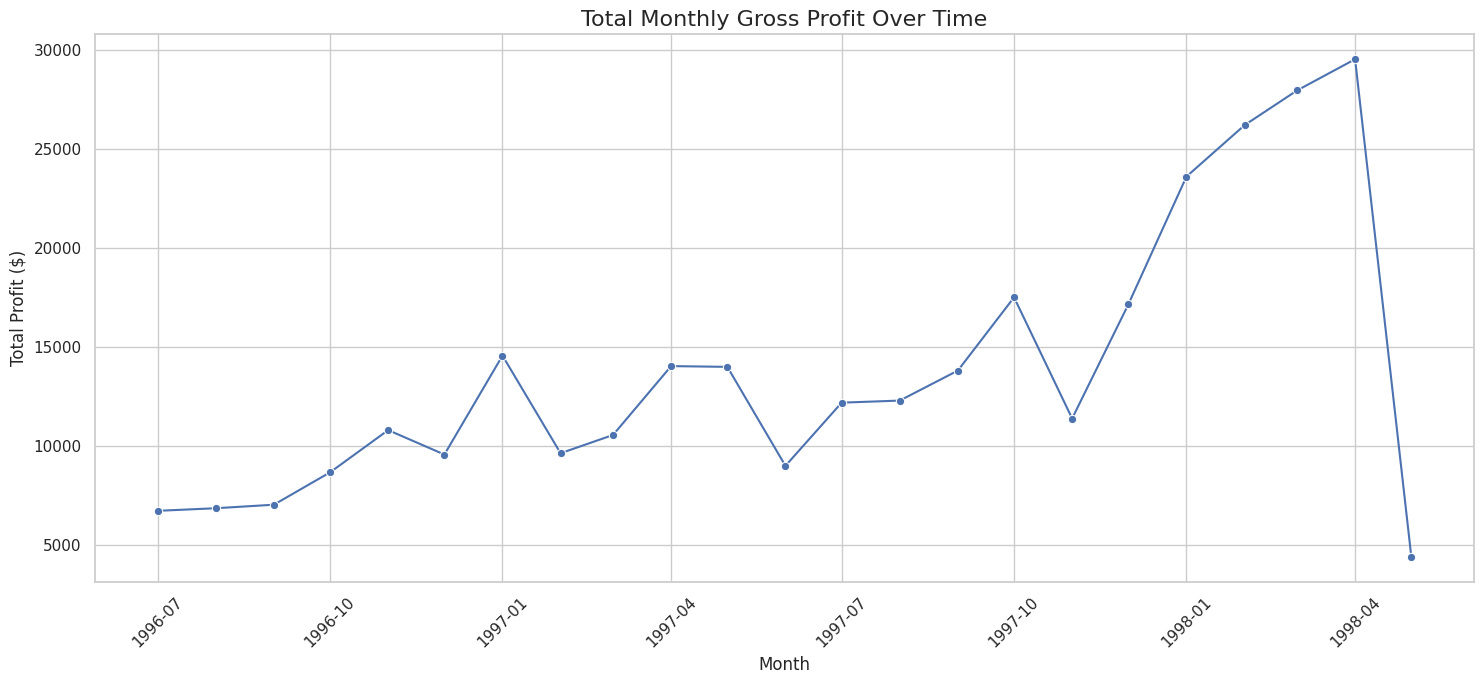


--- Generating Bar Chart for Top 5 vs. Bottom 5 Category Profit ---


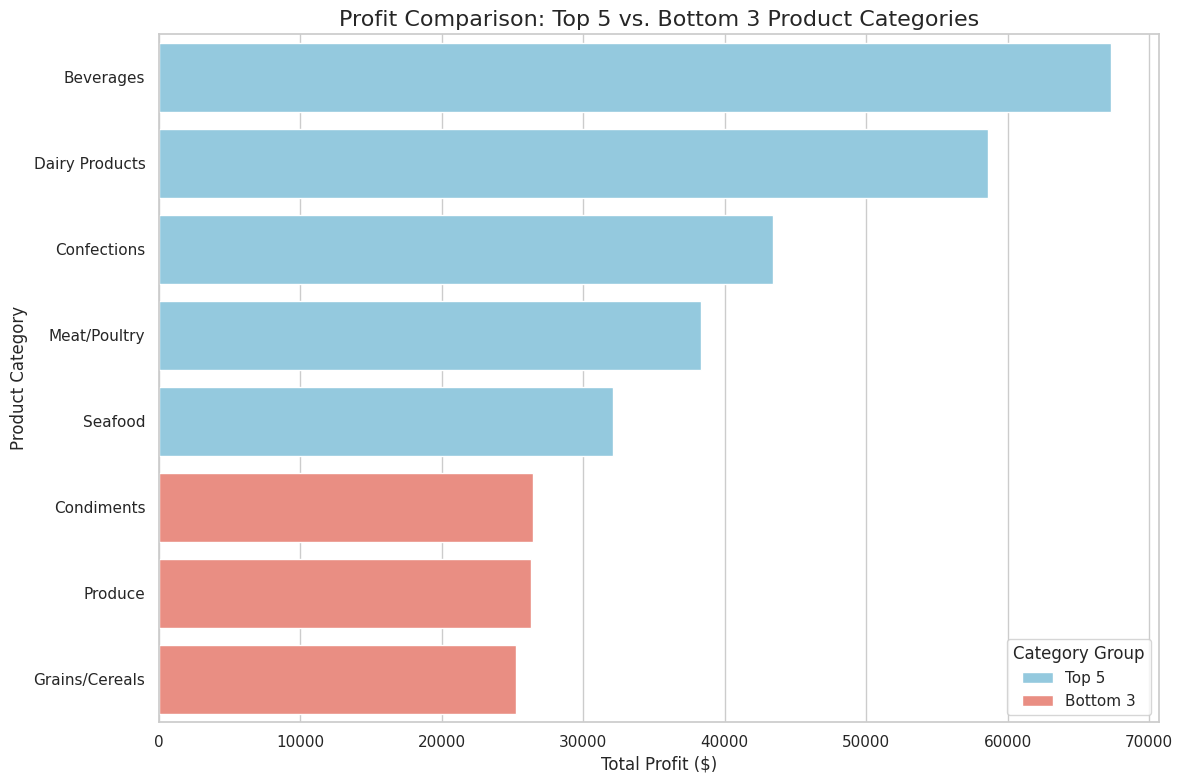

In [9]:
# --- Time Series Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Monthly Profit Trend Line Chart ---")

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Create a figure and axes for the plot
plt.figure(figsize=(15, 7))

# Prepare data for plotting by converting 'order_month' to timestamp
monthly_profit_plot = monthly_profit.copy()
monthly_profit_plot['order_month'] = monthly_profit_plot['order_month'].dt.to_timestamp()


# Create the line plot
sns.lineplot(data=monthly_profit_plot, x='order_month', y='total_profit', marker='o', color='b')

# Set plot titles and labels
plt.title('Total Monthly Gross Profit Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to make room for labels

# Display the plot
plt.show()

# --- Segment Comparison Visualization ---

# Create a bar chart to compare the total profit of the Top 5 vs. Bottom 5 product categories.
print("\n--- Generating Bar Chart for Top 5 vs. Bottom 5 Category Profit ---")

# Calculate total profit per category and sort
category_kpis_sorted = advanced_df.groupby('category_name')['item_profit'].sum().reset_index().sort_values(by='item_profit', ascending=False)

# Get the top 5 and bottom 5 categories
top_5_categories = category_kpis_sorted.head(5)
bottom_5_categories = category_kpis_sorted.tail(3) # Since there are only 8 categories, we take the last 3.

# Concatenate them into a single DataFrame for plotting
comparison_df = pd.concat([top_5_categories, bottom_5_categories])


# Create a color palette: one color for 'Top' and another for 'Bottom'
# Create a new column to indicate group
comparison_df['group'] = ['Top 5']*len(top_5_categories) + ['Bottom 3']*len(bottom_5_categories)
palette = {'Top 5': 'skyblue', 'Bottom 3': 'salmon'}

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=comparison_df, x='item_profit', y='category_name', hue='group', palette=palette, dodge=False)

# Set plot titles and labels
plt.title('Profit Comparison: Top 5 vs. Bottom 3 Product Categories', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.legend(title='Category Group')
plt.tight_layout()

# Display the plot
plt.show()

